In [ ]:
# ====== Imports ======
import os, random
import numpy as np
import pandas as pd
from scipy.stats import iqr
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F # Import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# ====== Colab drive mount ======
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile

# Path to the zip file in Colab
zip_file_path = '/content/MTF_16.zip'

# Directory to extract to
extract_to = '/content/MTVs/'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"File unzipped to {extract_to}")


File unzipped to /content/MTVs/


In [ ]:
# ====== Paths ======
IMG_DIR = "/content/MTVs"
CSV_PATH = "/content/target_train_488.csv"

TARGETS = ['Moi','NDF',  'Starch']
IMG_SIZE = 16 #------------------------------------------>16

In [ ]:
# ====== Load CSV ======
df = pd.read_csv(CSV_PATH)
# df = df.groupby('Sample ID').mean() # If the data is not averaged
# df = df.dropna(subset=TARGETS).reset_index(drop=True)
print("Data shape:", df.shape)

Data shape: (488, 3)


In [ ]:
# ====== Scale targets ======
from sklearn.preprocessing import StandardScaler
# y_scaler = MinMaxScaler()
y_scaler = StandardScaler() # => Auto scale
targets_scaled = y_scaler.fit_transform(df[TARGETS].values.astype(np.float32))

In [ ]:
plot_name = "MTF"  # Change this based on the plot type

In [ ]:
# ====== Dataset class (images already ready) ======

class SoilImageDataset(Dataset):
    def __init__(self, df, img_dir, targets_scaled, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.targets = targets_scaled.astype(np.float32)
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{plot_name}_{idx}.png")
        # Add a check to see if the image file exists
        if not os.path.exists(img_path):
            print(f"Error: Image file not found at {img_path} for index {idx}")
            # You might want to raise an error or handle this case differently
            # For now, we'll just print and continue, which might lead to subsequent errors
            # depending on how the DataLoader handles missing items.
            # A better approach might be to filter the DataFrame beforehand.
            raise FileNotFoundError(f"Image file not found at {img_path}") # Raising error to stop execution and show the path
        img = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))  # grayscale
        img = self.transform(img)  # shape (1,H,W)
        target = torch.from_numpy(self.targets[idx])
        return img, target

transform = transforms.Compose([
    transforms.ToTensor(),  # (H,W) -> (1,H,W), float in [0,1]
])

dataset = SoilImageDataset(df, IMG_DIR, targets_scaled, transform=transform)
print("Dataset length:", len(dataset))

Dataset length: 488


In [ ]:
# ====== CNN model (as in Table 2) ======
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, num_outputs=3): # Changed num_outputs to 3
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5a = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5b = nn.Conv2d(512, 512, 3, padding=1)

        self.flattened = 512 * 2 * 2
        self.fc1 = nn.Linear(self.flattened, 128)
        self.fc2 = nn.Linear(128, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool(x)
        x = self.relu(self.conv2(x)); x = self.pool(x)
        x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)
        x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)
        x = self.relu(self.conv5a(x)); x = self.relu(self.conv5b(x)); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
class SimpleCNN16x16(nn.Module):
    def __init__(self, in_channels=1, num_outputs=3):
        super(SimpleCNN16x16, self).__init__()

        # 16x16 input
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # Output: 32 @ 8x8

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # Output: 64 @ 4x4

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # Output: 128 @ 2x2

        # GAP to 1x1 or flatten from 128 @ 2x2
        # GAP to 1x1 from 128 @ 2x2 output: (Batch, 128, 1, 1)
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 64) # Input is from the GAP output channels
        self.fc2 = nn.Linear(64, num_outputs)
        self.dropout = nn.Dropout(0.2) # Reduced dropout as model is smaller

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

In [ ]:
# ====== Metrics ======
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        rpiq = float(iqr(yt) / rmse) if rmse > 1e-8 else float("inf")
        results.append({"RMSE": rmse, "R2": r2, "RPIQ": rpiq})
    return results

In [ ]:
# ====== Hyperparams ======
batch_size = 32
epochs = 1000
lr = 0.0001
n_splits = 5
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, Subset

# Assuming 'dataset', 'seed', 'batch_size' are defined in previous cells

TEST_SIZE = 0.25      # 25% for the final test set
VAL_SPLIT_RATIO = 0.20  # 20% of the remaining 75% will be for validation (~15% overall)

# ====== Initial Split: Separate Test Set (Re-running your original split) ======
indices = np.arange(len(dataset))
trainval_idx, test_idx = train_test_split(
    indices,
    test_size=TEST_SIZE,
    random_state=seed
)

# ====== Second Split: Separate Training and Validation Sets ======
train_idx, val_idx = train_test_split(
    trainval_idx,
    test_size=VAL_SPLIT_RATIO,
    random_state=seed
)

print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

Total dataset size: 488
Training set size: 292
Validation set size: 74
Test set size: 122


In [ ]:
# ====== 5-Fold CV ====== But more Verbose
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
for fold, (t_idx, v_idx) in enumerate(kf.split(trainval_idx)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    train_loader = DataLoader(Subset(dataset, trainval_idx[t_idx]), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(dataset, trainval_idx[v_idx]), batch_size=batch_size, shuffle=False)

    model = SimpleCNN16x16().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # Verbose mode
        if (epoch+1) % 1 == 0:  # This will print every epoch (verbose=2 equivalent in training)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = y_scaler.inverse_transform(preds)
            yb_orig = y_scaler.inverse_transform(yb_np)
            y_true.append(yb_orig); y_pred.append(preds_orig)
    y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

    # Compute and print metrics
    metrics = compute_metrics_orig(y_true, y_pred)
    for i, t in enumerate(TARGETS):
        print(f"{t}: RMSE={metrics[i]['RMSE']:.3f}, R2={metrics[i]['R2']:.3f}, RPIQ={metrics[i]['RPIQ']:.3f}")


Streaming output truncated to the last 5000 lines.
Epoch 24/1000, Loss: 0.4381
Epoch 25/1000, Loss: 0.6691
Epoch 26/1000, Loss: 0.6196
Epoch 27/1000, Loss: 0.5602
Epoch 28/1000, Loss: 0.3222
Epoch 29/1000, Loss: 0.6398
Epoch 30/1000, Loss: 0.3985
Epoch 31/1000, Loss: 0.4557
Epoch 32/1000, Loss: 2.5075
Epoch 33/1000, Loss: 0.4626
Epoch 34/1000, Loss: 0.1926
Epoch 35/1000, Loss: 1.7650
Epoch 36/1000, Loss: 0.7007
Epoch 37/1000, Loss: 0.7534
Epoch 38/1000, Loss: 0.1976
Epoch 39/1000, Loss: 0.6496
Epoch 40/1000, Loss: 0.7425
Epoch 41/1000, Loss: 0.7900
Epoch 42/1000, Loss: 1.7745
Epoch 43/1000, Loss: 0.9528
Epoch 44/1000, Loss: 0.3323
Epoch 45/1000, Loss: 1.7179
Epoch 46/1000, Loss: 1.2289
Epoch 47/1000, Loss: 0.4905
Epoch 48/1000, Loss: 0.4714
Epoch 49/1000, Loss: 0.5442
Epoch 50/1000, Loss: 1.2686
Epoch 51/1000, Loss: 0.4229
Epoch 52/1000, Loss: 0.9830
Epoch 53/1000, Loss: 1.4927
Epoch 54/1000, Loss: 0.5873
Epoch 55/1000, Loss: 0.7244
Epoch 56/1000, Loss: 0.1657
Epoch 57/1000, Loss: 0.67

In [ ]:
# ====== Calculate mean of the metrics obtained in each fold in CV ======

# Lists to store metrics for each fold
all_fold_metrics = {target: {"RMSE": [], "R2": [], "RPIQ": []} for target in TARGETS}

# ... (rest of the code from the previous cell for the CV loop)
# After computing metrics for each fold:
for i, t in enumerate(TARGETS):
     print(f"{t}: RMSE={metrics[i]['RMSE']:.3f}, R2={metrics[i]['R2']:.3f}, RPIQ={metrics[i]['RPIQ']:.3f}")
     all_fold_metrics[t]["RMSE"].append(metrics[i]["RMSE"])
     all_fold_metrics[t]["R2"].append(metrics[i]["R2"])
     all_fold_metrics[t]["RPIQ"].append(metrics[i]["RPIQ"])


Moi: RMSE=5.648, R2=0.214, RPIQ=1.389
NDF: RMSE=5.007, R2=-0.077, RPIQ=1.218
Starch: RMSE=7.912, R2=-0.287, RPIQ=1.057


Starting training (Max Epochs: 1000, Patience: 10, Min Improvement: 1e-05)...
Epoch 1/1000, Train Loss: 1.0238, Val Loss: 0.9692
  Moi: R2_cal=-0.196, R2_val=-0.005, RMSE_val=6.330
  NDF: R2_cal=-0.091, R2_val=-0.007, RMSE_val=5.388
  Starch: R2_cal=-0.038, R2_val=-0.001, RMSE_val=8.654
Epoch 2/1000, Train Loss: 1.5443, Val Loss: 0.9670
  Moi: R2_cal=0.111, R2_val=-0.007, RMSE_val=6.334
  NDF: R2_cal=0.011, R2_val=0.001, RMSE_val=5.368
  Starch: R2_cal=0.014, R2_val=-0.000, RMSE_val=8.652
Epoch 3/1000, Train Loss: 0.9092, Val Loss: 0.9561
  Moi: R2_cal=0.134, R2_val=0.022, RMSE_val=6.242
  NDF: R2_cal=0.022, R2_val=0.016, RMSE_val=5.327
  Starch: R2_cal=0.055, R2_val=0.009, RMSE_val=8.613
Epoch 4/1000, Train Loss: 0.8956, Val Loss: 0.9392
  Moi: R2_cal=0.168, R2_val=0.090, RMSE_val=6.022
  NDF: R2_cal=0.036, R2_val=0.034, RMSE_val=5.276
  Starch: R2_cal=0.032, R2_val=0.023, RMSE_val=8.551
Epoch 5/1000, Train Loss: 0.9738, Val Loss: 0.9336
  Moi: R2_cal=0.173, R2_val=0.152, RMSE_val=5.8

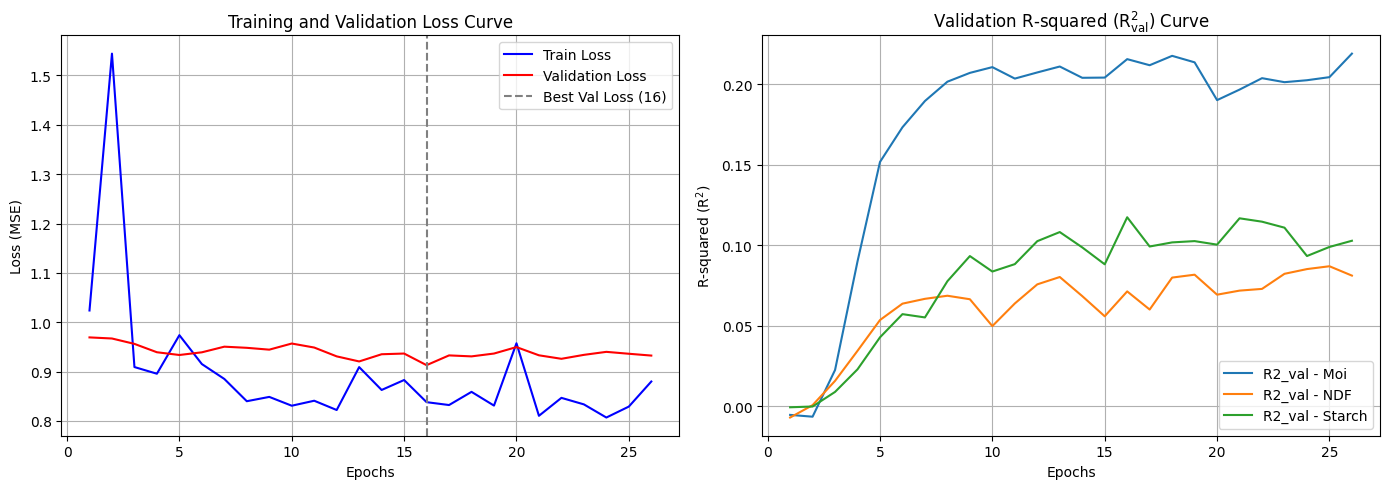

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Subset
import copy
from scipy.stats import iqr # Imported for the metric function
from sklearn.metrics import mean_squared_error, r2_score # Imported for the metric function

# --- Metric Function Definition (From your notebook cell 14) ---
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        # RPIQ calculation requires handling potential zero RMSE
        rpiq = float(iqr(yt) / rmse) if rmse > 1e-8 else float("inf")
        results.append({"RMSE": rmse, "R2": r2, "RPIQ": rpiq})
    return results
# ----------------------------------------------------------------------


# --- Configuration and Early Stopping Params ---
MAX_EPOCHS = 1000 # Max epochs as requested
MIN_IMPROVEMENT = 0.0001 # Minimum improvement required to reset patience
PATIENCE = 10 # Number of epochs to wait for improvement (can be adjusted)
lr=0.0001

# ====== Create Data Loaders ======
# Note: Using the new train_idx and val_idx from the previous split cell
train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)


# ====== Initialize the model, optimizer, and loss function ======
# Note: Assuming SimpleCNN16x16 is defined in a preceding cell.
final_model = SimpleCNN16x16().to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()


# ====== Initialize Trackers and Early Stopping ======
train_losses, val_losses = [], []
# Correctly initialized to only track the metrics returned by compute_metrics_orig
train_metrics = {target: {"RMSE": [], "R2": [], "RPIQ": []} for target in TARGETS}
val_metrics = {target: {"RMSE": [], "R2": [], "RPIQ": []} for target in TARGETS}

best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0
best_model_state = None


print(f"Starting training (Max Epochs: {MAX_EPOCHS}, Patience: {PATIENCE}, Min Improvement: {MIN_IMPROVEMENT})...")


# ====== Training Loop with Validation and Early Stopping ======
for epoch in range(MAX_EPOCHS):

    # --- A. Training Phase ---
    final_model.train()
    y_true_train_scaled, y_pred_train_scaled = [], []
    epoch_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Accumulate predictions (on scaled data) for epoch-end metric calculation
        y_true_train_scaled.append(yb.cpu().numpy())
        y_pred_train_scaled.append(preds.detach().cpu().numpy())

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Calculate and store Training Metrics (R2_cal)
    train_y_true_orig = y_scaler.inverse_transform(np.vstack(y_true_train_scaled))
    train_y_pred_orig = y_scaler.inverse_transform(np.vstack(y_pred_train_scaled))
    train_metrics_epoch = compute_metrics_orig(train_y_true_orig, train_y_pred_orig)

    for i, t in enumerate(TARGETS):
        metrics = train_metrics_epoch[i]
        for metric_name in ["RMSE", "R2", "RPIQ"]:
            train_metrics[t][metric_name].append(metrics[metric_name])


    # --- B. Validation Phase ---
    final_model.eval()
    y_true_val_scaled, y_pred_val_scaled = [], []
    val_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = final_model(xb)
            val_loss += criterion(preds, yb).item()

            y_true_val_scaled.append(yb.cpu().numpy())
            y_pred_val_scaled.append(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Calculate and store Validation Metrics (R2_val)
    val_y_true_orig = y_scaler.inverse_transform(np.vstack(y_true_val_scaled))
    val_y_pred_orig = y_scaler.inverse_transform(np.vstack(y_pred_val_scaled))
    val_metrics_epoch = compute_metrics_orig(val_y_true_orig, val_y_pred_orig)

    for i, t in enumerate(TARGETS):
        metrics = val_metrics_epoch[i]
        for metric_name in ["RMSE", "R2", "RPIQ"]:
            val_metrics[t][metric_name].append(metrics[metric_name])


    # --- C. Logging and Early Stopping ---

    # 1. Print current epoch results
    print(f"Epoch {epoch + 1}/{MAX_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    for i, t in enumerate(TARGETS):
        train_r2 = train_metrics[t]['R2'][-1]
        val_r2 = val_metrics[t]['R2'][-1]
        val_rmse = val_metrics[t]['RMSE'][-1]

        print(
            f"  {t}: R2_cal={train_r2:.3f}, "
            f"R2_val={val_r2:.3f}, "
            f"RMSE_val={val_rmse:.3f}"
        )

    # 2. Early Stopping Logic (based on Validation Loss)
    if avg_val_loss < best_val_loss - MIN_IMPROVEMENT:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        # Save the best model state
        best_model_state = copy.deepcopy(final_model.state_dict())
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"🚨 Early stopping triggered (Patience={PATIENCE}). Stopping at epoch {epoch + 1}.")
            break

# Load the best model weights found during training
if best_model_state:
    final_model.load_state_dict(best_model_state)
    print(f"Model restored to best state from Epoch {best_epoch}.")
else:
    print("No improvement threshold reached, using final epoch model state.")


# ====== 7. Plot Learning Curves ======
# Plotting both Loss curves and R2 curves for Training and Validation

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_ran = range(1, len(train_losses) + 1)

# --- Subplot 1: Loss Curves (Train vs Val) ---
axes[0].plot(epochs_ran, train_losses, label="Train Loss", color="blue")
axes[0].plot(epochs_ran, val_losses, label="Validation Loss", color="red")
if best_epoch > 0:
    axes[0].axvline(x=best_epoch, color='grey', linestyle='--', label=f'Best Val Loss ({best_epoch})')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss (MSE)")
axes[0].set_title("Training and Validation Loss Curve")
axes[0].legend()
axes[0].grid(True)

# --- Subplot 2: Validation R2 Metrics (All targets) ---
for t in TARGETS:
    # Use training R2 for comparison (R2_cal)
    # axes[1].plot(epochs_ran, train_metrics[t]["R2"], label=f'R2_cal - {t}', linestyle=':')
    # Only plotting validation curves for clarity as requested (Val Learning Curve)
    axes[1].plot(epochs_ran, val_metrics[t]["R2"], label=f'R2_val - {t}')

axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("R-squared ($\\text{R}^2$)")
axes[1].set_title("Validation R-squared ($\\text{R}^2_{\\text{val}}$) Curve")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"/content/{plot_name}_learning_curves_val.png")


<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1481223863.py:44: SyntaxWarning: invalid escape sequence '\m'
  axes[i].set_title(f"Regression Plot: {t} ($\mathbf{{R^2}}={test_metrics_list[i]['R2']:.3f}$)")


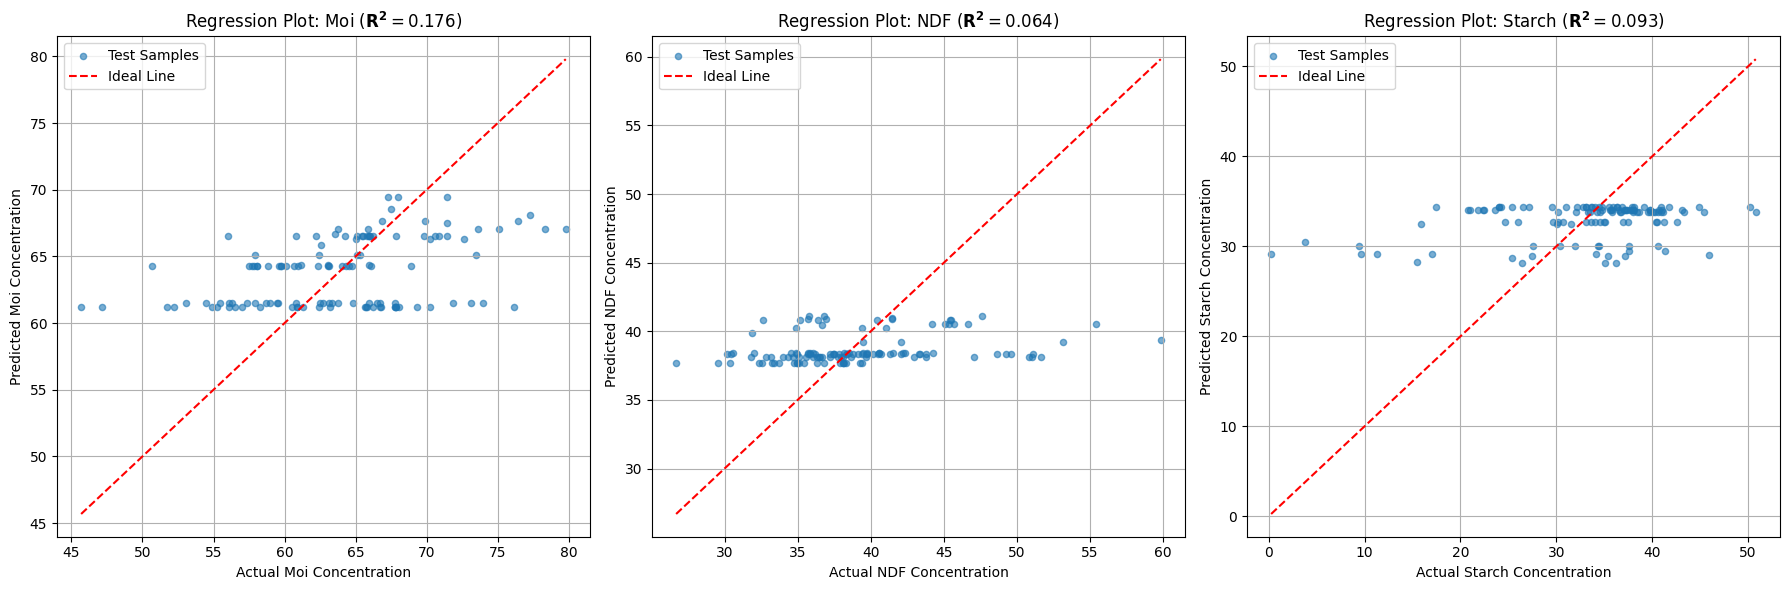


== Final Test Metrics ($\text{R}^2_{\text{test}}$) ==
🎯 Moi: R2_test=0.176, RMSE=5.680, RPIQ=1.419
🎯 NDF: R2_test=0.064, RMSE=5.434, RPIQ=1.101
🎯 Starch: R2_test=0.093, RMSE=8.219, RPIQ=0.965


In [ ]:
import matplotlib.pyplot as plt

# ====== 8. Final Evaluation on Test Set ======
final_model.eval()
y_true_scaled, y_pred_scaled = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = final_model(xb.to(device)).cpu().numpy()
        yb_np = yb.cpu().numpy()

        y_pred_scaled.append(preds)
        y_true_scaled.append(yb_np)

y_true_scaled = np.vstack(y_true_scaled)
y_pred_scaled = np.vstack(y_pred_scaled)

# Reverse scaling (if applicable) for final metrics
y_pred_orig = y_scaler.inverse_transform(y_pred_scaled)
y_true_orig = y_scaler.inverse_transform(y_true_scaled)

# Compute Test Metrics (R2_test)
test_metrics_list = compute_metrics_orig(y_true_orig, y_pred_orig)


# ====== PLOT REGRESSION CURVES (Actual vs. Predicted) ======
fig, axes = plt.subplots(1, len(TARGETS), figsize=(6 * len(TARGETS), 6))
if len(TARGETS) == 1:
    axes = [axes] # Ensure axes is iterable even for a single plot

for i, t in enumerate(TARGETS):
    # Scatter Plot of Actual (y_true) vs. Predicted (y_pred)
    axes[i].scatter(y_true_orig[:, i], y_pred_orig[:, i], alpha=0.6, label="Test Samples", s=20)

    # Calculate the min/max for the 1:1 line
    min_val = min(y_true_orig[:, i].min(), y_pred_orig[:, i].min())
    max_val = max(y_true_orig[:, i].max(), y_pred_orig[:, i].max())

    # Add 1:1 line
    axes[i].plot([min_val, max_val], [min_val, max_val],
                 '--', color='red', label="Ideal Line")

    # Set titles and labels
    axes[i].set_title(f"Regression Plot: {t} ($\mathbf{{R^2}}={test_metrics_list[i]['R2']:.3f}$)")
    axes[i].set_xlabel(f"Actual {t} Concentration")
    axes[i].set_ylabel(f"Predicted {t} Concentration")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.savefig(f"/content/{plot_name}_regression_curves.png") # Save the plot
plt.show()

# ====== Print results ======
print("\n== Final Test Metrics ($\\text{R}^2_{\\text{test}}$) ==")
for i, t in enumerate(TARGETS):
    test_metrics = test_metrics_list[i]
    print(
        f"🎯 {t}: "
        f"R2_test={test_metrics['R2']:.3f}, "
        f"RMSE={test_metrics['RMSE']:.3f}, "
        f"RPIQ={test_metrics['RPIQ']:.3f}"
    )
